In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
%matplotlib inline

In [11]:
def im_loader(fname):
    
    loaders = dict()
    
    def klb_loader(fname):
        from pyklb import readfull
        return readfull(str(fname))
            
    def h5_loader(fname):
        from h5py import File
        with File(fname) as f:
            return f['default'].value
        
    def tif_loader(fname):
        from skimage.io import imread
        return imread(fname)
    
    loaders['klb'] = klb_loader
    loaders['h5'] = h5_loader
    loaders['tif'] = tif_loader
    
    fmt = fname.split('.')[-1]
    
    return loaders[fmt](fname)

def guess_experimenter(fname):
        if fname.find('Yu') > 0:
            return 'yu'
        elif fname.find('davis') > 0:
            return 'davis'
        else:
            return ''

In [125]:
base_dirs = ('/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170113/fish2/20160113_2_1_cy14_7dpf_0gain_trial_20170113_124907/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170113/fish4/20160113_4_1_cy14_7dpf_0gain_trial_20170113_171241/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170131/fish4/20170131_4_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_193518/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170131/fish5/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_220542/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161022/fish1/20161022_1_1_cy221_6dpf_GA_0gain_20161022_151003/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161022/fish1/20161022_1_2_cy221_6dpf_dark_0gain_20161022_165648/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161019/fish3/20161019_3_1_GFAPGCaMP_6dpf_dark_0gain_20161019_201709/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish4/20170221_4_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_163236/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish4/20170221_4_4_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_185519/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20151119/20151119_1_1_dat_6d_mcherrynagative_GA_0GAIN_20151119_105108/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20160607/5dpf_cy171xcy221_f1_flash_1_20160607_205245/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20160607/5dpf_cy171xcy221_f1_omr_1_20160607_183009/')

# do different things to the directories depending on whether data are davis' or yu's
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
experimenter = guess_experimenter(paths['base'])

if experimenter is 'yu':
    print('These data are from Yu.')
    paths['raw'] = paths['base'] + 'raw/'
    paths['proj'] = paths['base'] + 'projections/'
    paths['reg'] = paths['base']    

elif experimenter is 'davis':
    print('These data are from Davis')    
    paths['raw'] = paths['base']
    paths['proc'] = paths['raw'].replace('raw', 'proc')
    paths['proj'] = paths['proc'] + 'proj/'
    paths['reg'] = paths['proc'] + 'reg/'
    
fnames = glob(paths['raw'] + 'TM*')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

from fish.image.vol import get_stack_freq
fs_im = 1 / get_stack_freq(paths['raw'])[0]    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(paths['raw'] + 'ch0.xml')
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)

from os.path import exists
if not exists(paths['proj']):
    from os import mkdir
    mkdir(paths['proj'])
else:
    print('Num existing projections: {0}'.format(len(glob(paths['proj'] + '*'))))

These data are from Davis
Num raw images: 5000
Sampling rate:  2.12 Hz


In [126]:
ims = td.images.fromlist(fnames, accessor=im_loader, engine=sc, npartitions=len(fnames)).median_filter(size=(1,3,3)).astype('float32')

In [127]:
ims.shape

(5000, 37, 2048, 2048)

In [128]:
%%time
do_registration = False

ref_range = (len(fnames) // 2) + np.arange(-5,5)
ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=im_loader)
ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('float32')

# save reference image to disk 
from skimage.io import imsave
imsave(paths['reg'] + 'anat_reference.tif', ref.astype('uint16'))

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
except(FileNotFoundError):
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/data/spim/proc/20160607/5dpf_cy171xcy221_f1_omr_1_20160607_183009/reg/anat_reference.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 1000]
CPU times: user 5min 49s, sys: 9.13 s, total: 5min 58s
Wall time: 27min 59s


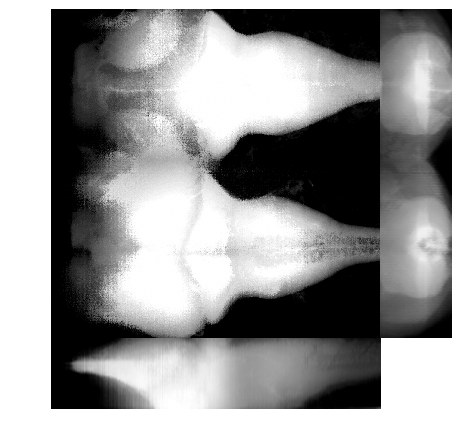

In [129]:
from fish.image.vol import proj_plot
mask = ref > 103
proj_plot(mask, np.mean, aspect=aspect);

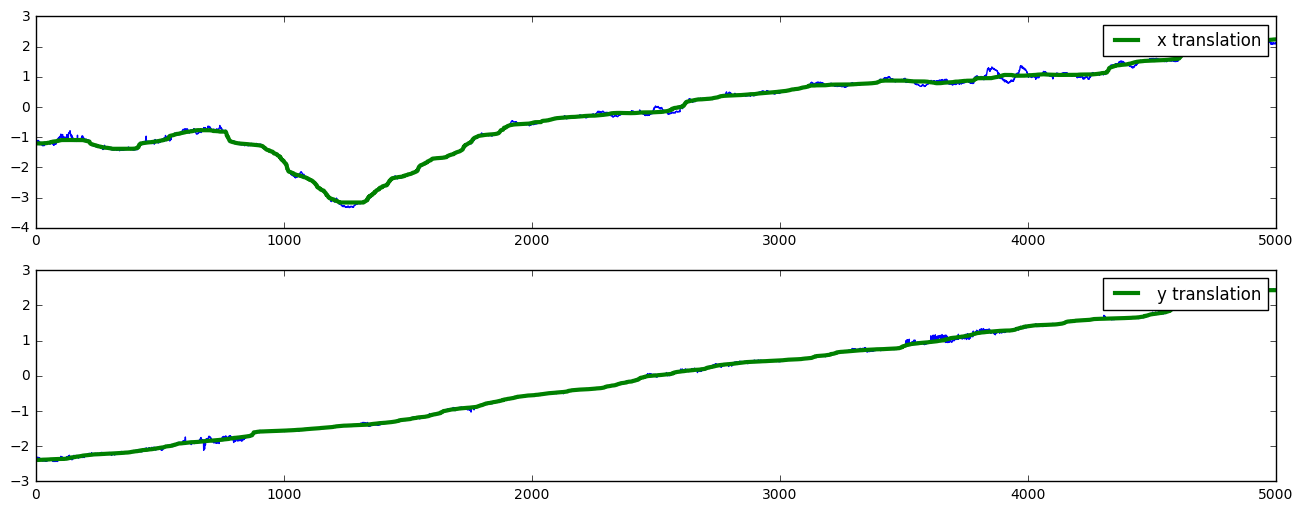

In [130]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

In [131]:
hist = np.histogram(ref.ravel()[::100], np.arange(ref.min(), ref.max()))
fill_val = np.round(hist[1][np.argmax(hist[0])])

In [132]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val), with_keys=True).astype('float32')

# send background pixels to 0
#ims_registered = ims_registered.map(lambda v: v * mask)

In [133]:
# generate local projections 
def my_proj(v, slab_z = 4):    
    from fish.image.vol import sub_proj    
    from numpy import amin, amax
    # number of planes per projection        
    n_slabs = int(np.ceil(v.shape[0] / slab_z))    
    chopped = sub_proj(v, 0, amin, n_slabs) + sub_proj(v, 0, amax, n_slabs)
    return chopped

# rescale the intensities of floating point data to an integer range
def rescale(v, in_range, out_range):    
    in_ptp = in_range[1] - in_range[0]
    out_ptp = out_range[1] - out_range[0]    
    rescaled = (((v - in_range[0]) * out_ptp) / in_ptp) + out_range[0]        
    return rescaled

# save the images
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

In [134]:
# take 300s baseline
baseline_window = int(300 / fs_im)
ds = 4
ser = ims_registered.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds].toseries()
ser = ser.normalize(method = 'window', window=baseline_window).astype('float32')
bounds = ser.map(lambda v: (v.min(), v.max())).toarray()

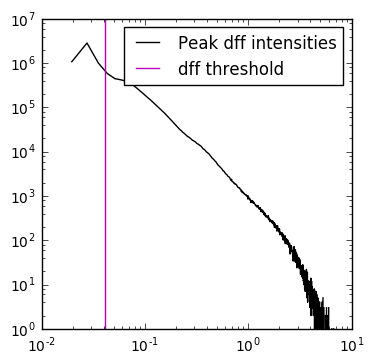

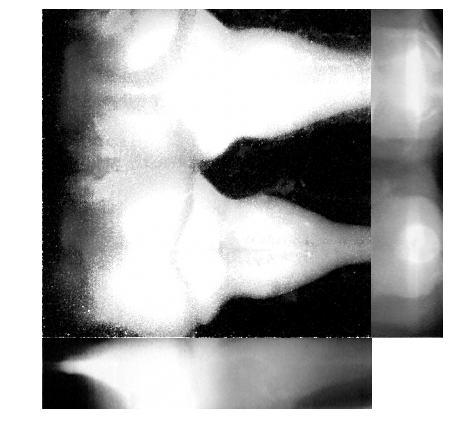

In [135]:
mx_vol = bounds[:,:,:,-1]
mn_vol = bounds[:,:,:,0]
hist_dff_mx = np.histogram(mx_vol.ravel(), np.linspace(mx_vol.min(), mx_vol.max(), 1000));
th_dff = 1.5 * hist_dff_mx[1][np.argmax(hist_dff_mx[0])]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
axs.plot(hist_dff_mx[1][:-1], hist_dff_mx[0],'k', label='Peak dff intensities')
axs.axvline(th_dff, color='m', label='dff threshold')
axs.legend()
axs.loglog()

from skimage.morphology import dilation, disk
mask_dff = mx_vol > th_dff
mask_dff = np.array([dilation(m, selem=disk(1)) for m in mask_dff])
proj_plot(mask_dff, np.mean, figsize=4, aspect=(aspect[0] // ds, aspect[1], aspect[2]));

## Apply dff-based mask and rescale

In [ ]:
mn, mx = (mn_vol * mask_dff).min(), (mx_vol * mask_dff).max()
out_range = (0, 4096)
slabs = ser.toimages().map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: v * mask_dff).map(my_proj).astype('int16')

## Save projections

In [ ]:
%%time
slabs.tordd().foreach(lambda v: save_ims(v, paths['proj']))

In [ ]:
%%bash
qdel -u bennettd